CELL 1 — Project Overview

# Smart City Issue Detection – YOLOv8 Inference Notebook

This notebook follows **industry standards** for:
- Dataset validation
- Dataset analysis
- Model evaluation
- Inference (batch + single image)
- Optional deployment preview (Gradio)

🔹 Model is **pre-trained** (`yolov8m.pt`)  
🔹 **No training** is performed in this notebook  
🔹 Dataset follows YOLO format


🟢 CELL 2 — Imports & Environment Setup

In [2]:
# Core Libraries
import os
import glob
import random
from pathlib import Path
from collections import Counter

# Data & Visualization
import yaml
import pandas as pd
import matplotlib.pyplot as plt

# Model
from ultralytics import YOLO

# Image handling
from PIL import Image

print("✅ Environment setup complete")


✅ Environment setup complete


🟢 CELL 3 — Define Project Paths (VERY IMPORTANT)

In [3]:
# Root paths (based on your folder structure)
DATA_DIR = Path("data")
DATA_YAML_PATH = DATA_DIR / "data.yaml"

TRAIN_LABELS = DATA_DIR / "train" / "labels"
VALID_LABELS = DATA_DIR / "valid" / "labels"
VALID_IMAGES = DATA_DIR / "valid" / "images"
TEST_IMAGES = DATA_DIR / "test" / "images"

MODEL_PATH = "yolov8m.pt"

print("✅ Paths configured")


✅ Paths configured


🟢 CELL 4 — Validate data.yaml (Industry Must-Have)

In [4]:
print("🔍 Checking data.yaml integrity...\n")

with open(DATA_YAML_PATH, "r") as f:
    config = yaml.safe_load(f)

print("YAML Content:")
print(yaml.dump(config, indent=2))

print("Dataset Info:")
print(f"Train path: {config.get('train')}")
print(f"Val path:   {config.get('val')}")
print(f"Classes:    {config.get('names')}")
print(f"Num classes:{config.get('nc')}")

print("\n✅ data.yaml validated")


🔍 Checking data.yaml integrity...

YAML Content:
names:
- garbage
- pothole
nc: 2
roboflow:
  license: CC BY 4.0
  project: smart-city-tm05d
  url: https://universe.roboflow.com/fourise/smart-city-tm05d/dataset/1
  version: 1
  workspace: fourise
test: ../test/images
train: ../train/images
val: ../valid/images

Dataset Info:
Train path: ../train/images
Val path:   ../valid/images
Classes:    ['garbage', 'pothole']
Num classes:2

✅ data.yaml validated


🟢 CELL 5 — Dataset Class Distribution Analysis

,Class ID,Class Name,Train,Validation,Total
0,0,garbage,2096,463,2559
1,1,pothole,2760,160,2920


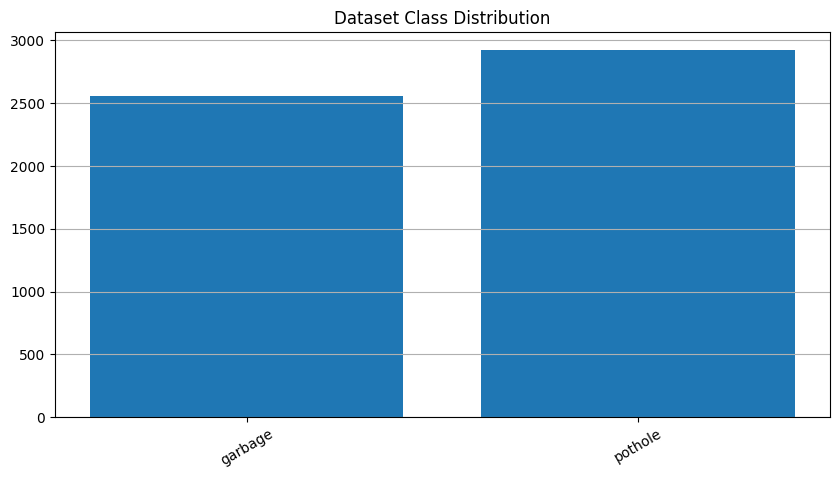

In [5]:
def count_classes(label_dir: Path):
    counts = Counter()
    for file in label_dir.glob("*.txt"):
        with open(file, "r") as f:
            for line in f:
                cls = int(float(line.split()[0]))
                counts[cls] += 1
    return counts

train_counts = count_classes(TRAIN_LABELS)
valid_counts = count_classes(VALID_LABELS)

class_names = config["names"]

data = []
for idx in sorted(set(train_counts) | set(valid_counts)):
    name = class_names[idx]
    t = train_counts.get(idx, 0)
    v = valid_counts.get(idx, 0)
    data.append([idx, name, t, v, t + v])

df = pd.DataFrame(
    data,
    columns=["Class ID", "Class Name", "Train", "Validation", "Total"]
)

display(df)

plt.figure(figsize=(10, 5))
plt.bar(df["Class Name"], df["Total"])
plt.title("Dataset Class Distribution")
plt.xticks(rotation=30)
plt.grid(axis="y")
plt.show()


🟢 CELL 6 — Load Trained YOLOv8 Model

In [6]:
print(f"📦 Loading model from: {MODEL_PATH}")
model = YOLO(MODEL_PATH)
print("✅ Model loaded successfully")


📦 Loading model from: yolov8m.pt
✅ Model loaded successfully


🟢 CELL 7 — Model Validation (Metrics)

In [7]:
print("📊 Running model validation...\n")

metrics = model.val(data=str(DATA_YAML_PATH))

print(f"mAP@0.5:      {metrics.box.map50:.4f}")
print(f"mAP@0.5:0.95: {metrics.box.map:.4f}")
print(f"Precision:    {metrics.box.mp:.4f}")
print(f"Recall:       {metrics.box.mr:.4f}")

print("\nClass-wise mAP:")
for i, name in model.names.items():
    print(f"{name}: {metrics.box.maps[i]:.4f}")


📊 Running model validation...

Ultralytics 8.3.235  Python-3.13.6 torch-2.9.1+cpu CPU (11th Gen Intel Core i5-1135G7 @ 2.40GHz)
Model summary (fused): 92 layers, 25,840,918 parameters, 0 gradients, 78.7 GFLOPs
val: Fast image access  (ping: 0.40.1 ms, read: 7.21.3 MB/s, size: 76.1 KB)
val: Scanning E:\Fourise\smart-city\data\valid\labels.cache... 562 images, 7 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 562/562 605.3Kit/s 0.0s
WARNING Box and segment counts should be equal, but got len(segments) = 56, len(boxes) = 623. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 36/36 8.2s/it 4:568.3ss
                   all        562        623      0.877      0.863      0.901      0.605
               garbage        434        463       0.87       0.87      0.878     

🟢 CELL 8 — Batch Inference on Validation Images

In [8]:
results = model.predict(
    source=str(VALID_IMAGES),
    conf=0.25,
    save=True,
    max_det=5
)

print(f"✅ Predictions saved in: {results[0].save_dir}")



image 1/562 e:\Fourise\smart-city\data\valid\images\-libre-place-des-dejections-en-plusieurs-langues-photo-marc-wirtz-1430300655_jpg.rf.68713b59445ee425b735eaea37ba54cd.jpg: 640x640 1 garbage, 556.1ms
image 2/562 e:\Fourise\smart-city\data\valid\images\-noir-C3A0-cC3B4tC3A9-de-la-clC3B4ture-du-bureau-C3A0-domicile-sur-la-rue-3r_jpg.rf.ce6098d66b1c44201dc4185b9bb5455e.jpg: 640x640 1 garbage, 600.5ms
image 3/562 e:\Fourise\smart-city\data\valid\images\000273202W_jpg.rf.4888eecd6115aebbf2e7e7f2ede0b1a7.jpg: 640x640 1 garbage, 408.0ms
image 4/562 e:\Fourise\smart-city\data\valid\images\004633f2-679f-11e5-b0e3-40f2e96c8ad8_jpg.rf.981d80f2caa60b7709d0abf06ed0ec45.jpg: 640x640 2 garbages, 415.0ms
image 5/562 e:\Fourise\smart-city\data\valid\images\0602669809922-web-tete_jpg.rf.6bc0a96f19e5c204f00a2fc66601b719.jpg: 640x640 2 garbages, 458.8ms
image 6/562 e:\Fourise\smart-city\data\valid\images\0bd7f188-679f-11e5-b0e3-40f2e96c8ad8_jpg.rf.87dc0891eaeab28102529cb75b38e74f.jpg: 640x640 1 garbage,

🟢 CELL 9 — Single Image Inference (Visual Verification)

🖼 Running inference on: youtube-26_jpg.rf.fe0960bee6b8a789bc33a42dd6afd3d8.jpg

image 1/1 e:\Fourise\smart-city\data\valid\images\youtube-26_jpg.rf.fe0960bee6b8a789bc33a42dd6afd3d8.jpg: 640x640 5 potholes, 432.6ms
Speed: 5.1ms preprocess, 432.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)
Results saved to E:\Fourise\Smart City Issue Detector\runs\detect\predict2


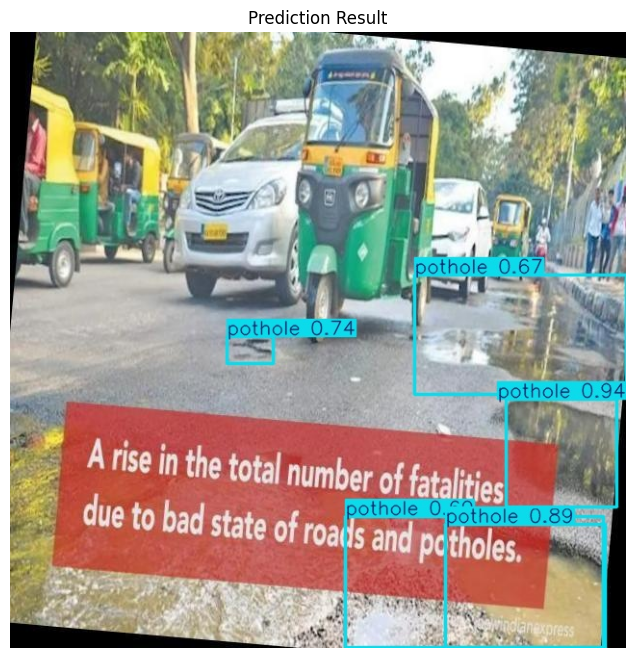

In [10]:
images = list(VALID_IMAGES.glob("*.jpg"))

sample = random.choice(images)
print(f"🖼 Running inference on: {sample.name}")

result = model.predict(sample, conf=0.25, save=True)

latest_run = sorted(Path("runs/detect").glob("predict*"))[-1]
output_img = latest_run / sample.name

img = Image.open(output_img)
plt.figure(figsize=(8, 8))
plt.imshow(img)
plt.axis("off")
plt.title("Prediction Result")
plt.show()


🟢 CELL 10 — Test Set Inference

🧪 Testing image: image353_jpeg_jpg.rf.6fad467a393e3f0787beb361be5a2031.jpg

image 1/1 e:\Fourise\smart-city\data\test\images\image353_jpeg_jpg.rf.6fad467a393e3f0787beb361be5a2031.jpg: 640x640 2 potholes, 2584.7ms
Speed: 346.0ms preprocess, 2584.7ms inference, 81.5ms postprocess per image at shape (1, 3, 640, 640)


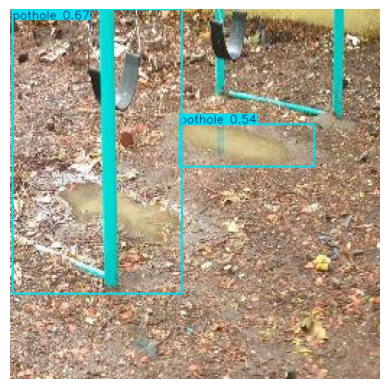

In [11]:
test_files = list(TEST_IMAGES.glob("*.jpg"))

if test_files:
    test_img = random.choice(test_files)
    print(f"🧪 Testing image: {test_img.name}")

    results = model.predict(test_img, conf=0.25)

    for r in results:
        im = Image.fromarray(r.plot()[..., ::-1])
        plt.imshow(im)
        plt.axis("off")
        plt.show()
else:
    print("❌ No test images found")
